# Calculating portfolio returns 
* This is the same exact file as portfolio investing but instead of using BTC, we have actual stock data

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
achc = pd.read_csv('ACHC.csv', parse_dates=['Date'])
achc = achc.sort_values(by='Date')
achc.set_index('Date', inplace=True)

In [4]:
# calculate daily returns
achc['Returns'] = achc['Adj Close'].pct_change()
achc['Returns'].head()

Date
2016-12-12         NaN
2016-12-13   -0.035675
2016-12-14   -0.037283
2016-12-15    0.035725
2016-12-16    0.019130
Name: Returns, dtype: float64

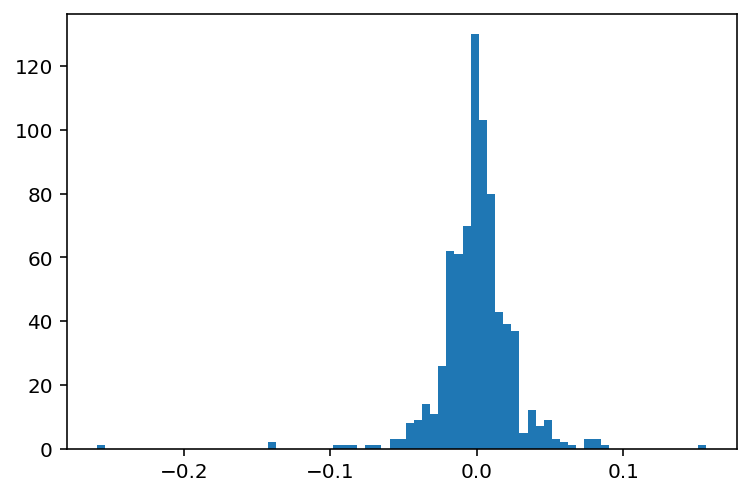

In [5]:
# visualize returns
plt.hist(achc['Returns'].dropna(), bins=75, density=False)
plt.show();

In order to build a backtest portfolio we need to have the returns of multiple assets in a single object

Our model portfolio consists of the following companies and the weight in our portfolio represented by percentages:
* Apple 12%
* Microsoft 15%
* Exxon Mobil 8%
* JP Morgan 9%
* Amazon 10%
* Facebook 5%
* AT&T 16%
* Tesla 15%
* Gold 10%

In [14]:
# calculate mean returns
mean_return_daily = np.mean(achc['Returns'])
print(mean_return_daily)

0.0001509405969682483


In [15]:
# calculate implied annualized average return assuming 252 trading days in a year
mean_return_annualized = ((1 + np.mean(achc['Returns'])) ** 252) - 1
print(mean_return_annualized)

0.03876671660452513


In [16]:
# standard deviation
sigma_daily = np.std(achc['Returns'])
print(sigma_daily)

0.024976457076131005


In [17]:
# calculate the variance, simply square the standard deviation
variance_daily = np.std(achc['Returns']) ** 2
print(variance_daily)

0.0006238234080758146


In [18]:
# calculate annualized standard deviation
sigma_annualized = sigma_daily * np.sqrt(252)
print(sigma_annualized)

# calculate annualized variance
variance_annualized = sigma_annualized ** 2
print(variance_annualized)

0.39648896432953246
0.15720349883510526


## Skewness and Kurtosis

In [19]:
from scipy.stats import skew

clean_returns = (achc['Returns'].dropna())

# calculate the third moment(skewness) of the returns distribution
returns_skewness = skew(clean_returns)
print(returns_skewness)

-1.5122829563227018


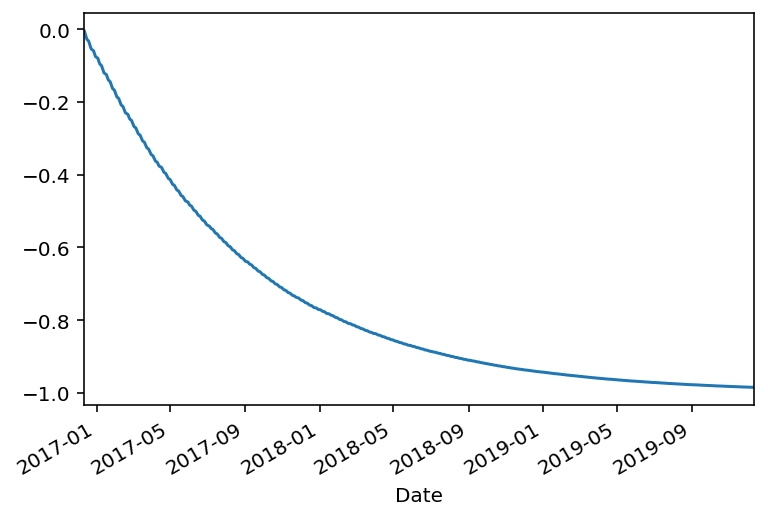

In [13]:
# define portoflio weights as numpy array
portfolio_weights = np.array([0.12, 0.15, 0.08, 0.09, 0.10, 0.05, 0.16, 0.15, 0.10])

# calculate the weighted stock returns
WeightedReturns = achc[:9]['Returns'].mul(portfolio_weights)

# calculate the portfolio returns
achc['Portfolio'] = WeightedReturns.sum()

# plot cumulative portfolio returns over time
CumulativeReturns = ((1 + achc['Portfolio']).cumprod()-1)
CumulativeReturns.plot()
plt.show();